In [85]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np

%matplotlib widget

In [86]:
from weylchamber import c1c2c3
from qiskit import QuantumCircuit
from slam.utils.gates.custom_gates import RiSwapGate
from qiskit.quantum_info import Operator
from slam.utils.visualize import coordinate_2dlist_weyl

In [87]:
# class pass_manager_basic(PassManager):
#     def __init__(self, gate='iswap'):
#         passes = []
#         # collect 2Q blocks
#         passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
#         if gate == 'iswap':
#             passes.extend([decomposer(basis_gate=RiSwapGate(1/2))])
#         elif gate == 'cx':
#             passes.extend([decomposer(basis_gate=CXGate())])
#         #combine 1Q gates
#         passes.extend([Optimize1qGates()])
#         #passes.extend([CountOps(), fooAnalysis()])
#         super().__init__(passes)

In [88]:
# #transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
# pm = pass_manager_basic(gate='iswap')
# qc = QuantumCircuit(2)
# qc.swap(0,1)
# transp1 = pm.run(qc)

In [89]:
# transp1.draw(output='mpl');

In [90]:
from slam.basisv2 import CircuitTemplateV2
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
basis.build(3)
basis.spanning_range = range(3,4)

#bound all Qs to be >0
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, 0.5, 0.5)

from slam.sampler import HaarSample, GateSample
from qiskit.circuit.library import CXGate, CZGate, SwapGate
from slam.utils.gates.custom_gates import CanonicalGate
sampler = GateSample(gate = SwapGate())
# sampler = GateSample(gate = CanonicalGate(np.pi / 4, np.pi / 8, np.pi/8))
# sampler = GateSample(gate = CXGate())
s = [s for s in sampler][0]

from slam.optimizer import TemplateOptimizer
from slam.cost_function import BasicCostInverse, BasicCost, SquareCost
objective1 = SquareCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, success_threshold = 1e-7, training_restarts=25)
_ret3 = optimizer3.approximate_target_U(s)

INFO:root:Begin search: (0.5, 0.5, 0.5)
INFO:root:Starting opt on template size 3
  0%|          | 0/25 [00:04<?, ?it/s]
INFO:root:Cycle (k =3), Best Loss=3.550885807612758e-09
INFO:root:Break on cycle 3
INFO:root:Overall Best Loss=3.550885807612758e-09
INFO:root:Success: (0.5, 0.5, 0.5), Found: (0.49999821, 0.49997201, 0.49996939)


In [91]:
basis.build(_ret3.cycles)
circuit =basis.assign_Xk(_ret3.Xk)
transp1 = circuit
circuit.draw()

┌────────────────────────────────────────────────────────┐┌──────────────┐»
q_0: ┤ U(-2.61282471126214,5.87519115731227,9.55187355596281) ├┤0             ├»
     ├────────────────────────────────────────────────────────┤│  Riswap(0.5) │»
q_1: ┤ U(3.30922668771516,3.71455141156687,-5.83945971440465) ├┤1             ├»
     └────────────────────────────────────────────────────────┘└──────────────┘»
«      ┌───────────────────────────────────────────────────────┐  »
«q_0: ─┤ U(4.71418913263553,2.40382605642589,7.67485471869844) ├──»
«     ┌┴───────────────────────────────────────────────────────┴─┐»
«q_1: ┤ U(-4.71053403005214,-7.00328167908988,-8.04063486397668) ├»
«     └──────────────────────────────────────────────────────────┘»
«     ┌──────────────┐┌───────────────────────────────────────────────────────┐»
«q_0: ┤0             ├┤ U(7.84862563826406,9.44285614361501,2.30856826810552) ├»
«     │  Riswap(0.5) │├───────────────────────────────────────────────────────┤»
«q_1: ┤1             ├┤ U(7.85928560541358,9.44027709402712,-3.9923157086907) ├»
«     └──────────────┘└───────────────────────────────────────────────────────┘»
«     ┌──────────────┐»
«q_0: ┤0             ├»
«     │  Riswap(0.5) │»
«q_1: ┤1             ├»
«     └──────────────┘»
«     ┌─────────────────────────────────────────────────────────┐
«q_0: ┤ U(-8.02163557359689,6.23150783297726,-1.52513705336573) ├
«     └─┬─────────────────────────────────────────────────────┬─┘
«q_1: ──┤ U(7.40864982824,2.35362024900011,-10.6962852585675) ├──
«       └─────────────────────────────────────────────────────┘

In [92]:
c1c2c3(Operator(transp1).data)

(0.49999821, 0.49997201, 0.49996939)

In [93]:
circuit[:2]
left_qc = QuantumCircuit(2)
for instruction, qargs, cargs in circuit[:8]:
    left_qc.append(instruction, qargs, cargs)
# left_qc.draw(output='mpl')
print(c1c2c3(Operator(left_qc).data))

right_qc = QuantumCircuit(2)
for instruction, qargs, cargs in circuit[3:]:
    right_qc.append(instruction, qargs, cargs)
# right_qc.draw(output='mpl')
print(c1c2c3(Operator(right_qc).data))

(0.49997065, 0.24999824, 0.24997135)
(0.49997455, 0.24999497, 0.24997053)


In [94]:
from qiskit.circuit import Parameter
def unbind_parameters(qc):
    i = 0
    out = qc.copy()
    for instr, qargs, cargs in out:
        if instr.params and instr.name =="riswap":
            # num_params = len(instr.params)
            # pvec.resize(len(pvec) + num_params)
            instr.params = [Parameter(f't{i}')]
            i +=1
    return out

transp1 = unbind_parameters(transp1)
transp1.draw()

┌────────────────────────────────────────────────────────┐┌─────────────┐»
q_0: ┤ U(-2.61282471126214,5.87519115731227,9.55187355596281) ├┤0            ├»
     ├────────────────────────────────────────────────────────┤│  Riswap(t0) │»
q_1: ┤ U(3.30922668771516,3.71455141156687,-5.83945971440465) ├┤1            ├»
     └────────────────────────────────────────────────────────┘└─────────────┘»
«      ┌───────────────────────────────────────────────────────┐  »
«q_0: ─┤ U(4.71418913263553,2.40382605642589,7.67485471869844) ├──»
«     ┌┴───────────────────────────────────────────────────────┴─┐»
«q_1: ┤ U(-4.71053403005214,-7.00328167908988,-8.04063486397668) ├»
«     └──────────────────────────────────────────────────────────┘»
«     ┌─────────────┐┌───────────────────────────────────────────────────────┐»
«q_0: ┤0            ├┤ U(7.84862563826406,9.44285614361501,2.30856826810552) ├»
«     │  Riswap(t1) │├───────────────────────────────────────────────────────┤»
«q_1: ┤1            ├┤ U(7.85928560541358,9.44027709402712,-3.9923157086907) ├»
«     └─────────────┘└───────────────────────────────────────────────────────┘»
«     ┌─────────────┐»
«q_0: ┤0            ├»
«     │  Riswap(t2) │»
«q_1: ┤1            ├»
«     └─────────────┘»
«     ┌─────────────────────────────────────────────────────────┐
«q_0: ┤ U(-8.02163557359689,6.23150783297726,-1.52513705336573) ├
«     └─┬─────────────────────────────────────────────────────┬─┘
«q_1: ──┤ U(7.40864982824,2.35362024900011,-10.6962852585675) ├──
«       └─────────────────────────────────────────────────────┘

In [95]:
from weylchamber import c1c2c3
endpoints = [5,8,11]
coordinate_list = []
#5:1 ratio of 2Q/1Q gate duration, plot 2Q as 25 poitns, 1Q as 5 points

for _ in range(5):
    coordinate_list.append((0,0,0))

for end in endpoints:
    qc = QuantumCircuit(2)
    for gate in transp1[0:end]:
        qc.append(gate[0], gate[1])

    # 2, 5, 8
    qc2 = qc.copy()
    for i in [2,5,8]:
        if i < end-3:
            qc2 = qc2.bind_parameters({qc2[i][0].params[0] : 0.5} )
        # add coordinate during 1Q gate
        #eliminating x-axis symmetry
        c = list(c1c2c3(Operator(qc3).data))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1
        for _ in range(5):
            coordinate_list.append(c)
    for t in np.linspace(0,.5, 25):
        qc3 = qc2.bind_parameters({qc2[end-3][0].params[0]: t})
        #eliminating x-axis symmetry
        c = list(c1c2c3(Operator(qc3).data))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1
        coordinate_list.append(c)

# qc2.draw(output='mpl')

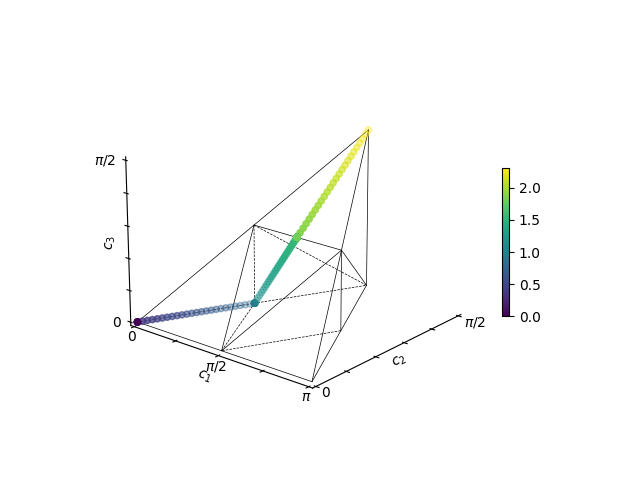

In [108]:
# from slam.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(coordinate_list, c=np.linspace(0, 1.5+.2*4, len(coordinate_list)));

In [106]:
coordinate_list[-25:]

[[0.49997065, 0.24999824, 0.24997135],
 [0.49997065, 0.26041491, 0.26038801],
 [0.49997065, 0.27083157, 0.27080468],
 [0.49997065, 0.28124824, 0.28122135],
 [0.49997065, 0.29166491, 0.29163801],
 [0.49997065, 0.30208157, 0.30205468],
 [0.49997065, 0.31249824, 0.31247135],
 [0.49997065, 0.32291491, 0.32288801],
 [0.49997065, 0.33333157, 0.33330468],
 [0.49997065, 0.34374824, 0.34372135],
 [0.49997065, 0.35416491, 0.35413801],
 [0.49997065, 0.36458157, 0.36455468],
 [0.49997065, 0.37499824, 0.37497135],
 [0.49997065, 0.38541491, 0.38538801],
 [0.49997065, 0.39583157, 0.39580468],
 [0.49997065, 0.40624824, 0.40622135],
 [0.49997065, 0.41666491, 0.41663801],
 [0.49997065, 0.42708157, 0.42705468],
 [0.49997065, 0.43749824, 0.43747135],
 [0.49997065, 0.44791491, 0.44788801],
 [0.49997065, 0.45833157, 0.45830468],
 [0.49997065, 0.46874824, 0.46872135],
 [0.49997065, 0.47916491, 0.47913801],
 [0.49997065, 0.48958157, 0.48955468],
 [0.49999821, 0.49997201, 0.49996939]]

In [97]:
# coordinate_list = []
# from slam.utils.gates.custom_gates import FSim, BerkeleyGate, CanonicalGate
# r = np.linspace(0,3,250)
# for t in r:
#     qc2 = QuantumCircuit(2)
#     #add fsim as a function of time
#     #qc2.append(FSim(1*np.pi/2, 1*np.pi/6).power(t), [0,1])
#     #qc2.append(CanonicalGate(np.pi / 4, np.pi / 8, np.pi/25).power(t), [0,1])
#     #eliminating x-axis symmetry
#     c = list(c1c2c3(Operator(qc2).data))
#     # if c[0] > 0.5:
#     #     c[0] = -1*c[0] + 1
#     coordinate_list.append(c)
# coordinate_2dlist_weyl(coordinate_list, c=r, cmap='viridis')